<a href="https://colab.research.google.com/github/pushpendra-saini-pks/WSD/blob/main/WSD_using_Lesk_%2CMEMM_and_Baseline_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install nltk senseval scikit-learn numpy

ERROR: Could not find a version that satisfies the requirement senseval (from versions: none)
ERROR: No matching distribution found for senseval


In [25]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import senseval
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict, Counter


In [26]:
nltk.download('senseval')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package senseval to /root/nltk_data...
[nltk_data]   Package senseval is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Defining MEMM

In [27]:
class MEMMWordSenseDisambiguator:
    def __init__(self):
        self.vectorizer = DictVectorizer(sparse=True)
        self.model = LogisticRegression(multi_class='multinomial', max_iter=1000)
        self.sense_mapping = {}
        self.reverse_sense_mapping = {}

    def extract_features(self, sentence, target_index):
        """Extract features for a target word in a sentence."""
        features = {}

        # The word itself
        target_word = sentence[target_index][0].lower()  # Access the word from the tuple
        features['word'] = target_word

        # Context window (2 words before and after)
        for i in range(-2, 3):
            if i != 0:  # Skip the target word
                idx = target_index + i
                if 0 <= idx < len(sentence):
                    features[f'context_{i}'] = sentence[idx][0].lower()  # Access the word from the tuple

        # POS tags (already available in the tuples)
        features['pos'] = sentence[target_index][1]

        # Surrounding POS tags
        for i in range(-2, 3):
            if i != 0:
                idx = target_index + i
                if 0 <= idx < len(sentence):
                    features[f'pos_{i}'] = sentence[idx][1]

        # WordNet features
        synsets = wn.synsets(target_word)
        if synsets:
            features['first_sense_pos'] = synsets[0].pos()
            features['num_senses'] = len(synsets)

        return features

    def prepare_senseval_data(self):
        """Prepare Senseval-2 data for training."""
        instances = senseval.instances('interest.pos')
        data = []
        labels = []

        for instance in instances:
            # instance.context already contains tuples of (word, pos_tag)
            sentence = instance.context
            target_index = instance.position
            features = self.extract_features(sentence, target_index)
            sense = instance.senses[0]  # Take first sense if multiple

            data.append(features)
            labels.append(sense)

        # Create sense mappings
        unique_senses = sorted(set(labels))
        self.sense_mapping = {sense: idx for idx, sense in enumerate(unique_senses)}
        self.reverse_sense_mapping = {idx: sense for sense, idx in self.sense_mapping.items()}

        # Convert string labels to numeric
        numeric_labels = [self.sense_mapping[label] for label in labels]


        return data, numeric_labels

    def fit(self, X_dict, y):
        """Train the MEMM model."""
        X = self.vectorizer.fit_transform(X_dict)
        self.model.fit(X, y)

    def predict(self, X_dict):
        """Make predictions using the trained model."""
        X = self.vectorizer.transform(X_dict)
        return self.model.predict(X)

    def get_sense_label(self, numeric_label):
        """Convert numeric label back to sense string."""
        return self.reverse_sense_mapping[numeric_label]

## Defining Lesk

In [28]:
class LeskDisambiguator:
    def __init__(self):
        pass

    def lesk_algorithm(self, sentence, target_word, target_index):
        """Simplified Lesk algorithm implementation."""
        context = set(word[0].lower() for word in sentence)  # Access words from tuples
        target_word = target_word[0].lower()  # Access word from tuple

        best_sense = None
        max_overlap = 0

        for synset in wn.synsets(target_word):
            # Create signature from definition and examples
            signature = set(word.lower() for word in word_tokenize(synset.definition()))
            for example in synset.examples():
                signature.update(word.lower() for word in word_tokenize(example))

            overlap = len(context.intersection(signature))

            if overlap > max_overlap:
                max_overlap = overlap
                best_sense = synset

        return best_sense.name() if best_sense else None


## Defining Baseline

In [29]:
class BaselineDisambiguator:
    def __init__(self):
        self.most_frequent_senses = {}

    def fit(self, data, labels):
        """Store most frequent sense for each word."""
        word_sense_counts = defaultdict(Counter)
        for features, label in zip(data, labels):
            word = features['word']
            word_sense_counts[word][label] += 1

        self.most_frequent_senses = {
            word: counts.most_common(1)[0][0]
            for word, counts in word_sense_counts.items()
        }

    def predict(self, data):
        """Predict most frequent sense for each word."""
        predictions = []
        for features in data:
            word = features['word']
            predictions.append(
                self.most_frequent_senses.get(word, max(self.most_frequent_senses.values(), key=list(self.most_frequent_senses.values()).count))
            )
        return predictions

## Evaluating the model performance

In [30]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

    return accuracy, precision, recall, f1

In [31]:
def main():
    # Initialize models
    memm = MEMMWordSenseDisambiguator()

    # Prepare data
    print("Preparing data...")
    features, labels = memm.prepare_senseval_data()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )

    # Train and evaluate MEMM
    print("\nTraining MEMM model...")
    memm.fit(X_train, y_train)
    memm_predictions = memm.predict(X_test)
    memm_metrics = evaluate_model(y_test, memm_predictions, "MEMM")

    # Train and evaluate Baseline
    print("\nTraining Baseline model...")
    baseline = BaselineDisambiguator()
    baseline.fit(X_train, y_train)
    baseline_predictions = baseline.predict(X_test)
    baseline_metrics = evaluate_model(y_test, baseline_predictions, "Baseline (Most Frequent Sense)")

    # Compare results
    print("\nModel Comparison:")
    models = ["MEMM", "Baseline"]
    metrics = [memm_metrics, baseline_metrics]

    for model, (acc, prec, rec, f1) in zip(models, metrics):
        print(f"\n{model}:")
        print(f"Accuracy: {acc:.3f}")
        print(f"F1-Score: {f1:.3f}")

if __name__ == "__main__":
    main()


Preparing data...

Training MEMM model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



MEMM Performance:
Accuracy: 0.914
Precision: 0.907
Recall: 0.914
F1-Score: 0.909

Training Baseline model...

Baseline (Most Frequent Sense) Performance:
Accuracy: 0.633
Precision: 0.481
Recall: 0.633
F1-Score: 0.529

Model Comparison:

MEMM:
Accuracy: 0.914
F1-Score: 0.909

Baseline:
Accuracy: 0.633
F1-Score: 0.529


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualize the model performance

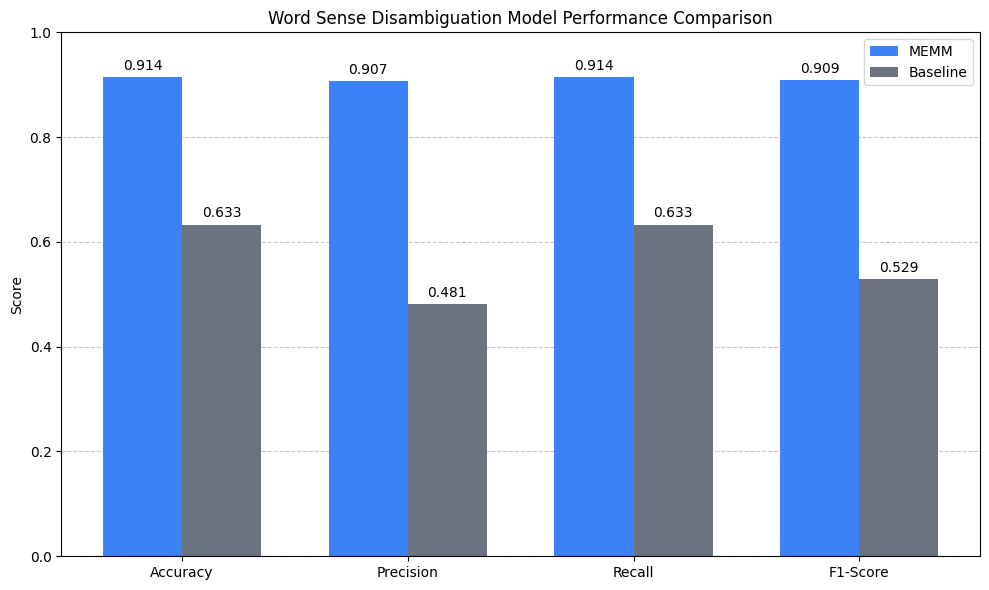

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_wsd_performance():
    # Performance metrics data
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    memm_scores = [0.914, 0.907, 0.914, 0.909]  # Updated MEMM scores
    baseline_scores = [0.633, 0.481, 0.633, 0.529]  # Updated Baseline scores

    # Set up the bar chart
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, memm_scores, width, label='MEMM', color='#3b82f6')
    rects2 = ax.bar(x + width/2, baseline_scores, width, label='Baseline', color='#6b7280')

    # Customize the plot
    ax.set_ylabel('Score')
    ax.set_title('Word Sense Disambiguation Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Set y-axis to start from 0 and end at 1
    ax.set_ylim(0, 1)

    # Add grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Add value labels on top of each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save the plot
    plt.savefig('wsd_performance.png', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

# Create and save the visualization
plot_wsd_performance()

